This note replicate the code and results in Restuccia, D., & Rogerson, R. (2008). [Policy distortions and aggregate productivity with heterogeneous establishments](https://uh.edu/~bsorense/RestucciaRogersonRED2008.pdf). Review of Economic dynamics, 11(4), 707-720.

In [1]:
from interpolation import interp
from scipy.optimize import brentq

## Calculate Equilibrium

- Consumer problem will determine steady-state rental rate of capital: 
$$R=r-\delta=\frac{1}{\beta}-1$$
- Whether to remain in operation equals to whether current period profits are non-negative since productivity does not change over time: 
$$\pi(s, \tau)=\max _{n, k \geqslant 0}\left\{(1-\tau) s k^{\alpha} n^{\gamma}-w n-r k-c_{f}\right\}$$, which implies
$$\bar{k}(s, \tau)=\left(\frac{\alpha}{r}\right)^{\frac{1-\gamma}{1-\gamma-\alpha}}\left(\frac{\gamma}{w}\right)^{\frac{\gamma}{1-\alpha-\gamma}}(s(1-\tau))^{\frac{1}{1-\alpha-\gamma}}$$
$$\bar{n}(s, \tau)=\left(\frac{(1-\tau) s \gamma}{w}\right)^{\frac{1}{1-\gamma}} k^{\frac{\alpha}{1-\gamma}}$$
- Zero profit condition for entry of establishments will determine steady-state wage rate: $$W_{e}=\sum_{(s, \tau)} \max _{\bar{x} \in\{0,1\}}\left\{\bar{x}(s, \tau) W(s, \tau) g(s, \tau)-c_{e}\right\}$$, where $W(s, \tau)=\frac{\pi(s, \tau)}{1-\rho}$, $\rho=\frac{1-\lambda}{1+R}$, and $g(s, \tau) = h(s) \times \mathcal{P}(s, \tau)$
- Labor market clearing determines the amount of entry: $$N(r, w)= \sum_{(s, \tau)} \bar{n}(s, \tau) \hat{\mu}(s, \tau) = 1$$
where 
$$\mu^{\prime}(s, \tau)=(1-\lambda) \mu(s, \tau)+\bar{x}(s, \tau) g(s, \tau) E$$
$$\hat{\mu}(s, \tau)=\frac{\bar{x}(s, \tau)}{\lambda} g(s, \tau)E
$$
- Government budget balance:
$$T+\sum_{(s, \tau)} \tau f(s, \bar{k}, \bar{n}) \mu(s, \tau)=0$$

- Note that we use a large grid compared to 100 used in the paper to mitigate the effect from randomization

In [2]:
class RR:
    def __init__(self,        
                    α = .85/3,    # target capital income share
                    γ = .85*2/3,  # target labor income share
                    β = .96,      # target real rate of return
                    δ = .08,      # target invetment to output ratio
                    ce = 1.0,      # normaization
                    cf = .0,       # bechmark case no fixed cost
                    λ = .1,       # annual exit rate
                    Ns = 5000       # number of grid points
                ):
        self.α, self.γ = α, γ
        self.β, self.δ = β, δ
        self.ce, self.cf = ce, cf
        self.λ = λ
        self.Ns = Ns
    
        self.r, self.R = self.r_star()
    
    def r_star(self,):
        β,δ = self.β, self.δ
        r = 1/β - (1 - δ)
        R = r - δ
        return r, R

    def k_demand(self, s, w, τ):
        α, γ, r = self.α, self.γ, self.r
        part1 = (α/r) ** ((1-γ)/(1-γ-α))
        part2 = (γ/w) ** (γ/(1-γ-α))
        part3 = (s * (1-τ)) ** (1/(1-γ-α))
        return part1 * part2 * part3

    def n_demand(self, s, k, w, τ):
        α, γ = self.α, self.γ
        part1 = ((1-τ)*s*γ/w) ** (1/(1-γ))
        part2 = k**(α/(1-γ))
        return part1 * part2
    
    def f(self, s, k, n,):
        α, γ = self.α, self.γ
        return s * k**α * n**γ

    def π(self, s, k, n, w, τ):
        r, cf = self.r, self.cf
        revenue = (1-τ) * self.f(s,k,n)
        cost = w*n + r*k + cf
        return revenue - cost
    
    @staticmethod
    def x_bar(π):
        return (π >= 0).astype(int)
        
    def W(self, π):
        λ, R = self.λ, self.R
        discount = (1-λ)/(1+R)
        return π/(1-discount)
        
    

In [3]:
m = RR()

### Impute grids from data

- Data from U.S. Census of Businesses (Rossi-Hansberg and Wright, AER 2007). All industries for 2000.
- US is treated as an economy with no distortions
- Use 
$$\frac{n_{i}}{n_{j}}=\left(\frac{s_{i}}{s_{j}}\right)^{\frac{1}{(1-\gamma-\alpha)}}$$ and normalizing the lowest level of establishment ($n=1$) productivity to 1 

In [4]:
df = pd.read_csv('reference/RR2008/files/establishment_dist.txt',
                 sep='\t',header=None, names=['n_uppers', 'hs'])
df = df.assign(Hs = np.cumsum(df.hs))

In [5]:
def imput_grids(m, df):
    α, γ = m.α, m.γ
    Ns = m.Ns 
    s_max = df.n_uppers.iloc[-1] ** (1-γ-α) # normalized s given s(n=1)=1
    s_vals = np.logspace(0, np.log(s_max)/np.log(10), Ns) # productivity grid
    n_vals = s_vals ** (1/(1-γ-α)) # size grid
    hs = np.zeros(Ns) # pmf
    n_uppers = np.r_[0, df.n_uppers.values]
    for i in range(len(n_uppers)-1):
        inds = (n_vals > n_uppers[i]) & (n_vals <= n_uppers[i+1]) 
        hs[inds] = df.hs.values[i] / sum(inds) if sum(inds) >0 else 0
    return s_vals, n_vals, hs

s_vals, n_vals, hs = imput_grids(m, df)

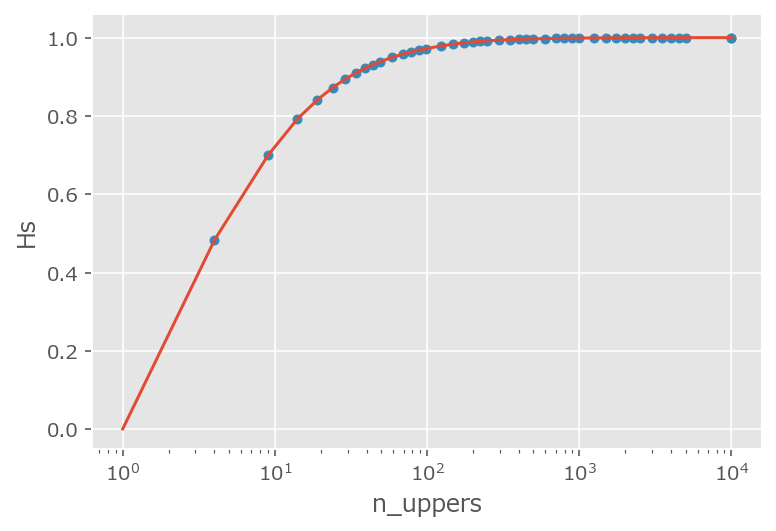

In [6]:
fig,ax=plt.subplots()
df.plot.scatter('n_uppers','Hs', ax=ax)
ax.plot(n_vals, np.cumsum(hs))
ax.set_xscale('log');

### Solve for benchmark economy

In [7]:
# in benchmark economy, no distortion
τ_vals = np.array([0])
P = np.ones((m.Ns, len(τ_vals)))
g = hs.reshape(m.Ns,1) * P

In [8]:
def solve_wage(m, s_vals, τ_vals, g,
               w_min=1e-2, w_max=10,
               output_diff_func=False):
    ce = m.ce
    s_grid = np.tile(s_vals, (len(τ_vals), 1)).T
    τ_grid = np.tile(τ_vals, (len(s_vals), 1))
    
    def free_entry_diff(w):
        k = m.k_demand(s_grid, w, τ_grid)
        n = m.n_demand(s_grid, k, w, τ_grid)
        π = m.π(s_grid, k, n, w, τ_grid)
        x_bar = m.x_bar(π)
        W = m.W(π)
        W_e = np.sum(x_bar*W*g) - ce
        return W_e
    
    if output_diff_func:
        return free_entry_diff
    
    assert free_entry_diff(w_min) > 0, "W_e(w_min) should be positive"
    assert free_entry_diff(w_max) < 0, "W_e(w_max) should be negative"
    
    w_star = brentq(free_entry_diff, w_min, w_max, )   
    k = m.k_demand(s_grid, w_star, τ_grid)
    n = m.n_demand(s_grid, k, w_star, τ_grid)
    π = m.π(s_grid, k, n, w_star, τ_grid)
    x_bar = m.x_bar(π)
    f_grid = m.f(s_grid, k, n)
    return w_star, n, k, x_bar, f_grid, τ_grid

In [9]:
# # plot W_e
# diff = solve_wage(m, s_vals, τ_vals, g, output_diff_func=True)
# w_ = np.linspace(0.6, 2, 100)
# W_e_ = np.empty(100)
# for i, w in enumerate(w_):
#     W_e_[i] = diff(w) 

# plt.plot(w_, W_e_);

In [10]:
w, n_grid, k_grid, x_bar, f_grid, τ_grid = solve_wage(m, s_vals, τ_vals, g)

In [11]:
def solve_entry(m, g, w, n_grid, x_bar, E_min, E_max):
    λ = m.λ
    def labor_market_diff(E,):
        μ = (x_bar/λ) * g * E
        N = np.sum(n_grid * μ)
        return N-1
    
    assert labor_market_diff(E_min) < 0, "N(E_min) should be < 1"
    assert labor_market_diff(E_max) > 0, "N(E_max) should be > 1"
    
    E_star = brentq(labor_market_diff, E_min, E_max, )
    μ = (x_bar/λ) * g * E_star
    return E_star, μ
    

In [12]:
E, μ = solve_entry(m, g, w, n_grid, x_bar, 1e-2, 10)

In [13]:
# lump sum tax
T = - np.sum(τ_grid * f_grid * μ) # here no distortion thus 0

In [14]:
# it seems when calculate Table 2 they use n_vals rather than n_grid
M = μ.sum()
np.sum(μ[n_vals < 5]) / M 

0.5419484961054183

In [15]:
# aggregate capital
K_nd = np.sum(μ * k_grid)
K_nd

7.807063965755106

In [16]:
# aggregate output
Y_nd = np.sum(μ * f_grid)
Y_nd

3.3524451147066068

## Quantitative analysis of distortions

### Uncorrelated idiosyncratic distortions

In [17]:
def solve_subsidy(m, τ, τ_s_min, τ_s_max, K_nd=K_nd,):
    def K_diff(τ_s):
        τ_vals = np.array([τ, τ_s])
        P = np.random.choice([0,1], (m.Ns,1), p=[.5,.5])
        P = np.c_[P,1-P]
        g = hs.reshape(m.Ns,1) * P
        w, n_grid, k_grid, x_bar, f_grid, τ_grid = solve_wage(m, s_vals, τ_vals, g)
        E, μ = solve_entry(m, g, w, n_grid, x_bar, 1e-2, 10)
        K = np.sum(μ * k_grid)
        return K - K_nd
    
    τ_s = brentq(K_diff, τ_s_min, τ_s_max, )
    return τ_s

In [18]:
for τ in [0.1, 0.2, 0.3, 0.4]:
    print(f'when τ = {τ}')
    τ_s = solve_subsidy(m, τ, -0.01, -0.2)
    τ_vals = np.array([τ, τ_s])
    P = np.random.choice([0,1], (m.Ns,1), p=[.5,.5])
    P = np.c_[P,1-P]
    g = hs.reshape(m.Ns,1) * P
    w, n_grid, k_grid, x_bar, f_grid, τ_grid = solve_wage(m, s_vals, τ_vals, g)
    E, μ = solve_entry(m, g, w, n_grid, x_bar, 1e-2, 10)
    Y = np.sum(μ * f_grid)
    print(f'relative_Y = {Y/Y_nd} ; τ_s = {τ_s}')

when τ = 0.1
relative_Y = 0.9837327783985457 ; τ_s = -0.06358905598582874
when τ = 0.2
relative_Y = 0.9547194724628698 ; τ_s = -0.08979102941561665
when τ = 0.3
relative_Y = 0.9310034664985306 ; τ_s = -0.10190472323987665
when τ = 0.4
relative_Y = 0.9141806522365276 ; τ_s = -0.1038610146730921


### Correlated idiosyncratic distortions